# Notebook: Preprocesamiento
## Proyecto: Pipeline NLP para Análisis de Twitter

**Fecha:** Octubre 2025  
**Dataset:** twitter_data_clean.csv
 
---

## 📋 Objetivos del Preprocesamiento
Preprocesamiento del Corpus para Pipeline NLP

In [1]:
# ============================================================================
# SECCIÓN 1: IMPORTACIONES Y CONFIGURACIÓN
# ============================================================================

import pandas as pd
import numpy as np
import re
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# NLP
import spacy
from spacy.lang.es.stop_words import STOP_WORDS as stopwords_es
import nltk
from nltk.corpus import stopwords

# Similitud de texto (Levenshtein)
from Levenshtein import distance as levenshtein_distance
from rapidfuzz import fuzz, process

# Visualización
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# Configuración de visualización
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 100)

print("=" * 80)
print("PREPROCESAMIENTO DEL CORPUS - PIPELINE NLP")
print("=" * 80)

PREPROCESAMIENTO DEL CORPUS - PIPELINE NLP


In [2]:
# ============================================================================
# SECCIÓN 2: CARGA DE DATOS
# ============================================================================

print("\n📂 CARGANDO DATASET...")
df = pd.read_csv('../data/twitter_data_clean.csv') 
print(f"✅ Dataset cargado: {df.shape[0]:,} filas × {df.shape[1]} columnas")
print(f"\nColumnas: {list(df.columns)}")


📂 CARGANDO DATASET...
✅ Dataset cargado: 162,969 filas × 5 columnas

Columnas: ['clean_text', 'category', 'text_length', 'word_count', 'char_count_no_spaces']


In [3]:
# ============================================================================
# SECCIÓN 3: LIMPIEZA INICIAL (Pre-preprocesamiento)
# ============================================================================

print("\n" + "=" * 80)
print("FASE 1: LIMPIEZA INICIAL")
print("=" * 80)

df_original_size = len(df)

# 3.1 Eliminar valores nulos
print("\n🧹 Eliminando valores nulos...")
null_before = df.isnull().sum().sum()
df = df.dropna(subset=['clean_text', 'category'])
null_after = df.isnull().sum().sum()
print(f"   ├─ Nulos eliminados: {null_before - null_after}")
print(f"   └─ Registros restantes: {len(df):,}")

# 3.2 Eliminar duplicados
print("\n🧹 Eliminando duplicados...")
dup_before = df.duplicated().sum()
df = df.drop_duplicates(subset=['clean_text'])
print(f"   ├─ Duplicados eliminados: {dup_before}")
print(f"   └─ Registros restantes: {len(df):,}")

# 3.3 Resetear índice
df = df.reset_index(drop=True)

# 3.4 Crear columna de longitud para filtrado
df['text_length'] = df['clean_text'].str.len()
df['word_count'] = df['clean_text'].str.split().str.len()

# 3.5 Eliminar textos muy cortos (< 10 caracteres)
print("\n🧹 Eliminando textos muy cortos (< 10 caracteres)...")
short_texts = len(df[df['text_length'] < 10])
df = df[df['text_length'] >= 10].copy()
print(f"   ├─ Textos cortos eliminados: {short_texts}")
print(f"   └─ Registros restantes: {len(df):,}")

# 3.6 Eliminar textos sospechosos (< 30% letras)
print("\n🧹 Eliminando textos sospechosos...")
def calculate_letter_ratio(text):
    if pd.isna(text) or len(text) == 0:
        return 0
    letters = sum(c.isalpha() for c in text)
    return letters / len(text)

df['letter_ratio'] = df['clean_text'].apply(calculate_letter_ratio)
suspicious_texts = len(df[df['letter_ratio'] < 0.3])
df = df[df['letter_ratio'] >= 0.3].copy()
print(f"   ├─ Textos sospechosos eliminados: {suspicious_texts}")
print(f"   └─ Registros restantes: {len(df):,}")

# Resumen de limpieza inicial
print("\n" + "─" * 80)
print(f"📊 RESUMEN DE LIMPIEZA INICIAL:")
print(f"   ├─ Registros iniciales: {df_original_size:,}")
print(f"   ├─ Registros finales: {len(df):,}")
print(f"   └─ Registros eliminados: {df_original_size - len(df):,} ({((df_original_size - len(df))/df_original_size)*100:.2f}%)")



FASE 1: LIMPIEZA INICIAL

🧹 Eliminando valores nulos...
   ├─ Nulos eliminados: 0
   └─ Registros restantes: 162,969

🧹 Eliminando duplicados...
   ├─ Duplicados eliminados: 0
   └─ Registros restantes: 162,969

🧹 Eliminando textos muy cortos (< 10 caracteres)...
   ├─ Textos cortos eliminados: 379
   └─ Registros restantes: 162,590

🧹 Eliminando textos sospechosos...
   ├─ Textos sospechosos eliminados: 4
   └─ Registros restantes: 162,586

────────────────────────────────────────────────────────────────────────────────
📊 RESUMEN DE LIMPIEZA INICIAL:
   ├─ Registros iniciales: 162,969
   ├─ Registros finales: 162,586
   └─ Registros eliminados: 383 (0.24%)


In [4]:
# ============================================================================
# SECCIÓN 4: FUNCIONES DE LIMPIEZA DE TEXTO
# ============================================================================

print("\n" + "=" * 80)
print("FASE 2: DEFINICIÓN DE FUNCIONES DE LIMPIEZA")
print("=" * 80)

def remove_urls(text):
    """Elimina URLs del texto"""
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    return url_pattern.sub('', text)

def remove_emojis(text):
    """Elimina emojis del texto"""
    emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # símbolos & pictogramas
        u"\U0001F680-\U0001F6FF"  # transporte & símbolos de mapa
        u"\U0001F1E0-\U0001F1FF"  # banderas
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        "]+", flags=re.UNICODE)
    return emoji_pattern.sub('', text)

def remove_special_chars(text):
    """Elimina caracteres especiales excepto espacios"""
    # Mantener letras, números y espacios
    text = re.sub(r'[^a-záéíóúñü\s]', ' ', text)
    return text

def remove_numbers(text):
    """Elimina números del texto"""
    return re.sub(r'\d+', '', text)

def remove_extra_whitespace(text):
    """Elimina espacios múltiples"""
    return re.sub(r'\s+', ' ', text).strip()

def clean_text_pipeline(text):
    """Pipeline completo de limpieza de texto"""
    if pd.isna(text):
        return ""
    
    text = str(text)
    text = text.lower()  # Ya está en minúsculas, pero por si acaso
    text = remove_urls(text)
    text = remove_emojis(text)
    text = remove_special_chars(text)
    text = remove_numbers(text)
    text = remove_extra_whitespace(text)
    
    return text

print("✅ Funciones de limpieza definidas")


FASE 2: DEFINICIÓN DE FUNCIONES DE LIMPIEZA
✅ Funciones de limpieza definidas


In [5]:
# ============================================================================
# SECCIÓN 5: APLICAR LIMPIEZA DE TEXTO
# ============================================================================

print("\n" + "=" * 80)
print("FASE 3: LIMPIEZA DE TEXTO")
print("=" * 80)

print("\n🧹 Aplicando pipeline de limpieza de texto...")
df['cleaned_text'] = df['clean_text'].apply(clean_text_pipeline)

# Verificar que no quedaron textos vacíos
empty_texts = (df['cleaned_text'].str.strip() == '').sum()
if empty_texts > 0:
    print(f"\n⚠️  Eliminando {empty_texts} textos que quedaron vacíos después de la limpieza...")
    df = df[df['cleaned_text'].str.strip() != ''].copy()

print(f"✅ Limpieza completada. Registros restantes: {len(df):,}")

# Ejemplos de antes y después
print("\n📝 EJEMPLOS DE LIMPIEZA:")
print("─" * 80)
sample_indices = df.sample(3).index
for i, idx in enumerate(sample_indices, 1):
    print(f"\n[Ejemplo {i}]")
    print(f"ANTES : {df.loc[idx, 'clean_text'][:150]}")
    print(f"DESPUÉS: {df.loc[idx, 'cleaned_text'][:150]}")


FASE 3: LIMPIEZA DE TEXTO

🧹 Aplicando pipeline de limpieza de texto...
✅ Limpieza completada. Registros restantes: 162,586

📝 EJEMPLOS DE LIMPIEZA:
────────────────────────────────────────────────────────────────────────────────

[Ejemplo 1]
ANTES : ambani and adani are making the policy then why elect modi elect them unopposed rafale deal was given man who has never made aircraft his life why not
DESPUÉS: ambani and adani are making the policy then why elect modi elect them unopposed rafale deal was given man who has never made aircraft his life why not

[Ejemplo 2]
ANTES : really but congress communists isi and hafeez sayeed and entire opposition wants that modi should not get reelected are they all cartel
DESPUÉS: really but congress communists isi and hafeez sayeed and entire opposition wants that modi should not get reelected are they all cartel

[Ejemplo 3]
ANTES : she didnt accuse state govt this time know why cuz its congress ruled state had this unfortunate incident happened

In [6]:
# ============================================================================
# SECCIÓN 6: CARGA DE MODELO spaCy Y PROCESAMIENTO NLP
# ============================================================================

print("\n" + "=" * 80)
print("FASE 4: PROCESAMIENTO NLP CON spaCy")
print("=" * 80)

print("\n📦 Cargando modelo de spaCy para español...")
try:
    nlp = spacy.load('es_core_news_sm')
    print("✅ Modelo 'es_core_news_sm' cargado correctamente")
except:
    print("❌ Error: Modelo no encontrado")
    print("   Ejecuta: python -m spacy download es_core_news_sm")
    raise

# Configurar pipeline de spaCy (desactivar componentes innecesarios para velocidad)
nlp.max_length = 2000000  # Aumentar límite si es necesario

# Cargar stopwords en español
print("\n📚 Cargando stopwords...")
# spaCy stopwords
spacy_stopwords = stopwords_es

# NLTK stopwords (opcional, como backup)
try:
    nltk_stopwords = set(stopwords.words('spanish'))
except:
    print("⚠️  Descargando stopwords de NLTK...")
    nltk.download('stopwords', quiet=True)
    nltk_stopwords = set(stopwords.words('spanish'))

# Combinar ambos conjuntos
all_stopwords = spacy_stopwords.union(nltk_stopwords)

# Añadir stopwords personalizadas si es necesario (palabras específicas del dominio)
custom_stopwords = {'modi', 'rt', 'pm'}  # Ajusta según tu análisis
all_stopwords = all_stopwords.union(custom_stopwords)

print(f"✅ Total de stopwords: {len(all_stopwords)}")


FASE 4: PROCESAMIENTO NLP CON spaCy

📦 Cargando modelo de spaCy para español...
✅ Modelo 'es_core_news_sm' cargado correctamente

📚 Cargando stopwords...
✅ Total de stopwords: 672


In [7]:
# ============================================================================
# SECCIÓN 7: TOKENIZACIÓN Y LEMATIZACIÓN
# ============================================================================

print("\n" + "=" * 80)
print("FASE 5: TOKENIZACIÓN Y LEMATIZACIÓN")
print("=" * 80)

def process_text_spacy(text, remove_stopwords=True, lemmatize=True):
    """
    Procesa texto con spaCy: tokenización, lematización y remoción de stopwords
    """
    doc = nlp(text)
    
    tokens = []
    for token in doc:
        # Filtrar tokens que no son palabras (puntuación, espacios, etc.)
        if not token.is_alpha:
            continue
        
        # Filtrar stopwords
        if remove_stopwords and token.text.lower() in all_stopwords:
            continue
        
        # Filtrar tokens muy cortos (< 2 caracteres)
        if len(token.text) < 2:
            continue
        
        # Usar lema o texto original
        if lemmatize:
            tokens.append(token.lemma_.lower())
        else:
            tokens.append(token.text.lower())
    
    return tokens

print("\n🔄 Procesando textos con spaCy...")
print("   (Esto puede tomar varios minutos dependiendo del tamaño del dataset)")

# Procesar en lotes para mejor rendimiento
batch_size = 1000
total_batches = len(df) // batch_size + 1

all_tokens = []
all_lemmas_text = []

for i in range(0, len(df), batch_size):
    batch = df['cleaned_text'].iloc[i:i+batch_size]
    batch_tokens = [process_text_spacy(text) for text in batch]
    all_tokens.extend(batch_tokens)
    all_lemmas_text.extend([' '.join(tokens) for tokens in batch_tokens])
    
    if (i // batch_size) % 10 == 0:
        print(f"   Procesado: {i:,} / {len(df):,} textos ({(i/len(df)*100):.1f}%)")

print(f"✅ Procesamiento completado: {len(df):,} textos")

# Agregar columnas al DataFrame
df['tokens'] = all_tokens
df['lemmatized_text'] = all_lemmas_text
df['token_count'] = df['tokens'].apply(len)

# Filtrar textos que quedaron sin tokens
empty_after_processing = (df['token_count'] == 0).sum()
if empty_after_processing > 0:
    print(f"\n⚠️  Eliminando {empty_after_processing} textos sin tokens después del procesamiento...")
    df = df[df['token_count'] > 0].copy()

print(f"\n📊 Estadísticas después del procesamiento:")
print(f"   ├─ Promedio de tokens por documento: {df['token_count'].mean():.2f}")
print(f"   ├─ Mediana de tokens: {df['token_count'].median():.0f}")
print(f"   └─ Tokens totales: {df['token_count'].sum():,}")

# Ejemplos de tokenización
print("\n📝 EJEMPLOS DE TOKENIZACIÓN Y LEMATIZACIÓN:")
print("─" * 80)
for i, idx in enumerate(df.sample(3).index, 1):
    print(f"\n[Ejemplo {i}]")
    print(f"ORIGINAL     : {df.loc[idx, 'cleaned_text'][:100]}")
    print(f"TOKENS       : {df.loc[idx, 'tokens'][:15]}")
    print(f"LEMATIZADO   : {df.loc[idx, 'lemmatized_text'][:100]}")


FASE 5: TOKENIZACIÓN Y LEMATIZACIÓN

🔄 Procesando textos con spaCy...
   (Esto puede tomar varios minutos dependiendo del tamaño del dataset)
   Procesado: 0 / 162,586 textos (0.0%)
   Procesado: 10,000 / 162,586 textos (6.2%)
   Procesado: 20,000 / 162,586 textos (12.3%)
   Procesado: 30,000 / 162,586 textos (18.5%)
   Procesado: 40,000 / 162,586 textos (24.6%)
   Procesado: 50,000 / 162,586 textos (30.8%)
   Procesado: 60,000 / 162,586 textos (36.9%)
   Procesado: 70,000 / 162,586 textos (43.1%)
   Procesado: 80,000 / 162,586 textos (49.2%)
   Procesado: 90,000 / 162,586 textos (55.4%)
   Procesado: 100,000 / 162,586 textos (61.5%)
   Procesado: 110,000 / 162,586 textos (67.7%)
   Procesado: 120,000 / 162,586 textos (73.8%)
   Procesado: 130,000 / 162,586 textos (80.0%)
   Procesado: 140,000 / 162,586 textos (86.1%)
   Procesado: 150,000 / 162,586 textos (92.3%)
   Procesado: 160,000 / 162,586 textos (98.4%)
✅ Procesamiento completado: 162,586 textos

📊 Estadísticas después del proc

In [8]:
# ============================================================================
# SECCIÓN 8: ANÁLISIS DE LEVENSHTEIN PARA ERRORES ORTOGRÁFICOS
# ============================================================================

print("\n" + "=" * 80)
print("FASE 6: DETECCIÓN DE ERRORES ORTOGRÁFICOS (LEVENSHTEIN)")
print("=" * 80)

# Crear vocabulario de palabras más frecuentes (diccionario)
print("\n📚 Construyendo vocabulario de referencia...")
all_words = [token for tokens in df['tokens'] for token in tokens]
word_freq = Counter(all_words)

# Usar las top 1000 palabras más frecuentes como diccionario de referencia
top_n = 1000
reference_vocab = set([word for word, _ in word_freq.most_common(top_n)])
print(f"✅ Vocabulario de referencia: {len(reference_vocab)} palabras")

def find_typos(tokens, reference_vocab, threshold=2):
    """
    Encuentra posibles errores ortográficos usando distancia de Levenshtein
    """
    typos = []
    corrections = []
    
    for token in tokens:
        if token not in reference_vocab and len(token) > 3:
            # Buscar palabra más similar en el vocabulario
            matches = process.extract(token, reference_vocab, scorer=fuzz.ratio, limit=1)
            if matches:
                best_match, score = matches[0][0], matches[0][1]
                lev_dist = levenshtein_distance(token, best_match)
                
                # Si la distancia es pequeña, es probable que sea un error
                if lev_dist <= threshold and score > 80:
                    typos.append(token)
                    corrections.append(best_match)
    
    return typos, corrections

print("\n🔍 Detectando posibles errores ortográficos...")
print("   (Analizando muestra de 1000 documentos)")

# Analizar muestra para no demorar demasiado
sample_df = df.sample(min(1000, len(df)))
all_typos = []
all_corrections = []

for tokens in sample_df['tokens']:
    typos, corrections = find_typos(tokens, reference_vocab)
    all_typos.extend(typos)
    all_corrections.extend(corrections)

# Crear DataFrame de errores comunes
if all_typos:
    typo_df = pd.DataFrame({
        'typo': all_typos,
        'correction': all_corrections
    })
    typo_counts = typo_df.groupby(['typo', 'correction']).size().reset_index(name='count')
    typo_counts = typo_counts.sort_values('count', ascending=False).head(20)
    
    print("\n📊 TOP 20 POSIBLES ERRORES ORTOGRÁFICOS DETECTADOS:")
    print("─" * 80)
    print(typo_counts.to_string(index=False))
else:
    print("✅ No se detectaron errores ortográficos significativos")


FASE 6: DETECCIÓN DE ERRORES ORTOGRÁFICOS (LEVENSHTEIN)

📚 Construyendo vocabulario de referencia...
✅ Vocabulario de referencia: 1000 palabras

🔍 Detectando posibles errores ortográficos...
   (Analizando muestra de 1000 documentos)

📊 TOP 20 POSIBLES ERRORES ORTOGRÁFICOS DETECTADOS:
────────────────────────────────────────────────────────────────────────────────
          typo      correction  count
         tough          though      6
          asks             ask      6
          note             not      5
         congi            cong      5
          kiya             kya      5
      promises         promise      5
     decisions        decision      4
      credited          credit      4
       missing         mission      4
        stroke          strike      4
      contests         contest      4
congratulation congratulations      4
      expected          expect      4
          star           start      4
       serious       seriously      4
          lack          

In [9]:
# ============================================================================
# SECCIÓN 9: ESTADÍSTICAS FINALES DEL PREPROCESAMIENTO
# ============================================================================

print("\n" + "=" * 80)
print("ESTADÍSTICAS FINALES DEL PREPROCESAMIENTO")
print("=" * 80)

# Vocabulario final
final_vocab = set([token for tokens in df['tokens'] for token in tokens])
total_tokens = sum(df['token_count'])

print(f"\n📊 ESTADÍSTICAS GENERALES:")
print(f"   ├─ Documentos finales: {len(df):,}")
print(f"   ├─ Total de tokens: {total_tokens:,}")
print(f"   ├─ Vocabulario único: {len(final_vocab):,}")
print(f"   ├─ Diversidad léxica: {len(final_vocab)/total_tokens:.4f}")
print(f"   └─ Promedio tokens/doc: {df['token_count'].mean():.2f}")

print(f"\n📈 ESTADÍSTICAS POR CLASE:")
class_stats = df.groupby('category').agg({
    'cleaned_text': 'count',
    'token_count': ['mean', 'median', 'sum']
}).round(2)
print(class_stats)

# Top 20 palabras más frecuentes
print(f"\n🔝 TOP 20 PALABRAS MÁS FRECUENTES (después del preprocesamiento):")
print("─" * 80)
top_words = word_freq.most_common(20)
for i, (word, count) in enumerate(top_words, 1):
    print(f"   {i:2d}. {word:20s} │ {count:,} veces")


ESTADÍSTICAS FINALES DEL PREPROCESAMIENTO

📊 ESTADÍSTICAS GENERALES:
   ├─ Documentos finales: 162,586
   ├─ Total de tokens: 3,053,743
   ├─ Vocabulario único: 104,330
   ├─ Diversidad léxica: 0.0342
   └─ Promedio tokens/doc: 18.78

📈 ESTADÍSTICAS POR CLASE:
         cleaned_text token_count                
                count        mean median      sum
category                                         
-1.0            35498       22.47   23.0   797528
 0.0            54910       13.12   11.0   720577
 1.0            72178       21.28   21.0  1535638

🔝 TOP 20 PALABRAS MÁS FRECUENTES (después del preprocesamiento):
────────────────────────────────────────────────────────────────────────────────
    1. the                  │ 104,505 veces
    2. and                  │ 67,365 veces
    3. for                  │ 52,445 veces
    4. you                  │ 38,980 veces
    5. not                  │ 29,435 veces
    6. will                 │ 28,946 veces
    7. this                 │ 28


GENERANDO VISUALIZACIONES
✅ Gráficas guardadas: preprocessing_stats.png


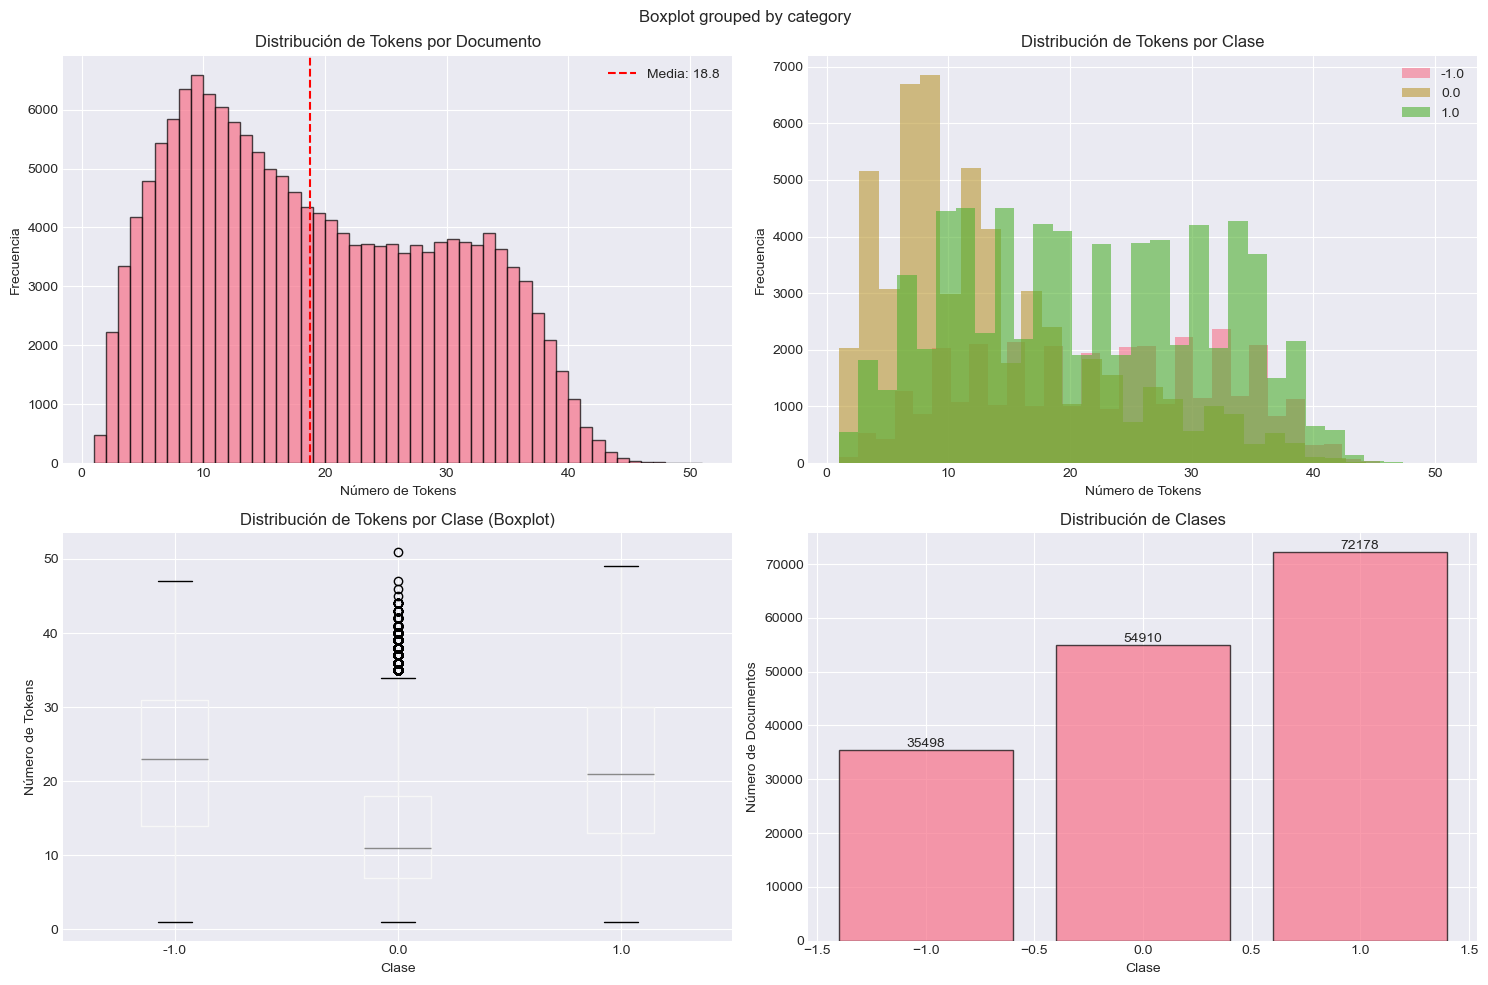


📊 Generando nubes de palabras por clase...
✅ Nubes de palabras guardadas: wordclouds_by_class.png


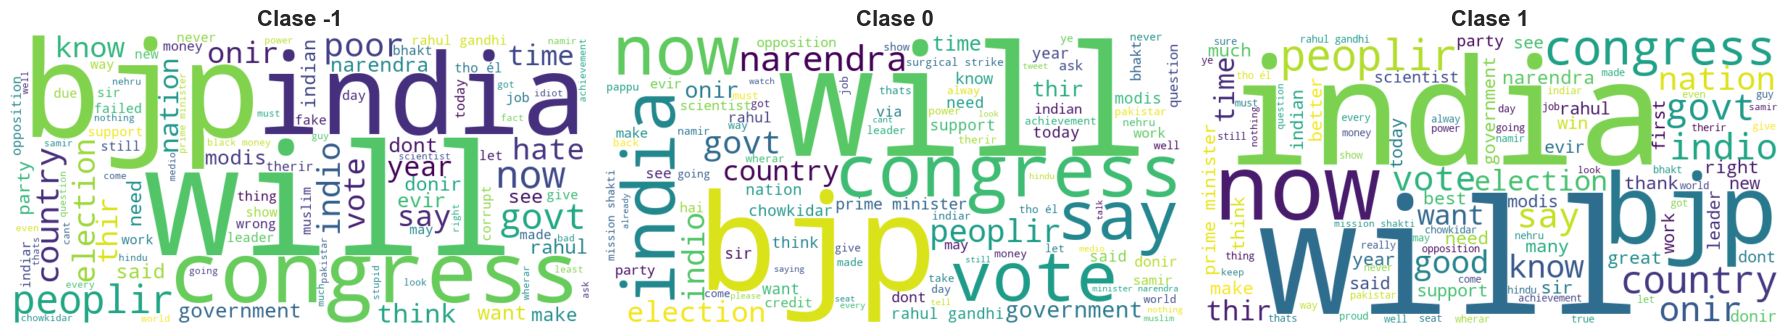

In [11]:
# ============================================================================
# SECCIÓN 10: VISUALIZACIONES
# ============================================================================

print("\n" + "=" * 80)
print("GENERANDO VISUALIZACIONES")
print("=" * 80)

# 10.1 Distribución de longitudes
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Distribución de longitud de tokens
axes[0, 0].hist(df['token_count'], bins=50, edgecolor='black', alpha=0.7)
axes[0, 0].set_xlabel('Número de Tokens')
axes[0, 0].set_ylabel('Frecuencia')
axes[0, 0].set_title('Distribución de Tokens por Documento')
axes[0, 0].axvline(df['token_count'].mean(), color='red', linestyle='--', label=f'Media: {df["token_count"].mean():.1f}')
axes[0, 0].legend()

# Distribución por clase
df.groupby('category')['token_count'].plot(kind='hist', bins=30, alpha=0.6, ax=axes[0, 1], legend=True)
axes[0, 1].set_xlabel('Número de Tokens')
axes[0, 1].set_ylabel('Frecuencia')
axes[0, 1].set_title('Distribución de Tokens por Clase')

# Boxplot por clase
df.boxplot(column='token_count', by='category', ax=axes[1, 0])
axes[1, 0].set_xlabel('Clase')
axes[1, 0].set_ylabel('Número de Tokens')
axes[1, 0].set_title('Distribución de Tokens por Clase (Boxplot)')
plt.sca(axes[1, 0])
plt.xticks(rotation=0)

# Conteo por clase
class_counts = df['category'].value_counts().sort_index()
axes[1, 1].bar(class_counts.index, class_counts.values, edgecolor='black', alpha=0.7)
axes[1, 1].set_xlabel('Clase')
axes[1, 1].set_ylabel('Número de Documentos')
axes[1, 1].set_title('Distribución de Clases')
for i, v in enumerate(class_counts.values):
    axes[1, 1].text(class_counts.index[i], v, str(v), ha='center', va='bottom')

plt.tight_layout()
plt.savefig('../results/preprocessing_stats.png', dpi=300, bbox_inches='tight')
print("✅ Gráficas guardadas: preprocessing_stats.png")
plt.show()

# 10.2 Nube de palabras por clase
print("\n📊 Generando nubes de palabras por clase...")
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for i, cat in enumerate(sorted(df['category'].unique())):
    # Obtener texto de la clase
    class_text = ' '.join(df[df['category'] == cat]['lemmatized_text'])
    
    # Generar nube de palabras
    wordcloud = WordCloud(width=800, height=400, 
                          background_color='white',
                          colormap='viridis',
                          max_words=100).generate(class_text)
    
    axes[i].imshow(wordcloud, interpolation='bilinear')
    axes[i].axis('off')
    axes[i].set_title(f'Clase {int(cat)}', fontsize=16, fontweight='bold')

plt.tight_layout()
plt.savefig('../results/wordclouds_by_class.png', dpi=300, bbox_inches='tight')
print("✅ Nubes de palabras guardadas: wordclouds_by_class.png")
plt.show()

In [13]:
# ============================================================================
# SECCIÓN 11: GUARDAR DATOS PREPROCESADOS
# ============================================================================

print("\n" + "=" * 80)
print("GUARDANDO DATOS PREPROCESADOS")
print("=" * 80)

# Seleccionar columnas finales
df_final = df[['cleaned_text', 'lemmatized_text', 'tokens', 'token_count', 'category']].copy()

# Guardar en diferentes formatos
print("\n💾 Guardando archivos...")

# CSV con texto lematizado (para modelos clásicos)
df_final.to_csv('../data/processed/preprocessed_data.csv', index=False)
print("   ✅ preprocessed_data.csv")

# Pickle con tokens (para análisis más profundo)
df_final.to_pickle('../data/processed/preprocessed_data.pkl')
print("   ✅ preprocessed_data.pkl")

# Guardar vocabulario
vocab_df = pd.DataFrame(word_freq.most_common(), columns=['word', 'frequency'])
vocab_df.to_csv('../data/processed/vocabulary.csv', index=False)
print("   ✅ vocabulary.csv")

# Guardar estadísticas del preprocesamiento
stats = {
    'total_documents': len(df_final),
    'total_tokens': int(total_tokens),
    'vocabulary_size': len(final_vocab),
    'avg_tokens_per_doc': float(df_final['token_count'].mean()),
    'median_tokens_per_doc': float(df_final['token_count'].median()),
    'lexical_diversity': float(len(final_vocab) / total_tokens),
    'class_distribution': df_final['category'].value_counts().to_dict()
}

import json
with open('../data/processed/preprocessing_stats.json', 'w') as f:
    json.dump(stats, f, indent=4)
print("   ✅ preprocessing_stats.json")

print("\n" + "=" * 80)
print("✅ PREPROCESAMIENTO COMPLETADO EXITOSAMENTE")
print("=" * 80)
print(f"\n📁 Archivos generados en: ../data/processed/")
print(f"   ├─ preprocessed_data.csv")
print(f"   ├─ preprocessed_data.pkl")
print(f"   ├─ vocabulary.csv")
print(f"   └─ preprocessing_stats.json")
print(f"\n📊 Datos listos para:")
print(f"   ├─ Representación de texto (BoW, TF-IDF, embeddings)")
print(f"   ├─ Modelos probabilísticos (N-gramas)")
print(f"   └─ Clasificación supervisada")
print("\n" + "=" * 80)


GUARDANDO DATOS PREPROCESADOS

💾 Guardando archivos...
   ✅ preprocessed_data.csv
   ✅ preprocessed_data.pkl
   ✅ vocabulary.csv
   ✅ preprocessing_stats.json

✅ PREPROCESAMIENTO COMPLETADO EXITOSAMENTE

📁 Archivos generados en: ../data/processed/
   ├─ preprocessed_data.csv
   ├─ preprocessed_data.pkl
   ├─ vocabulary.csv
   └─ preprocessing_stats.json

📊 Datos listos para:
   ├─ Representación de texto (BoW, TF-IDF, embeddings)
   ├─ Modelos probabilísticos (N-gramas)
   └─ Clasificación supervisada

